# Includes

In [1]:
import os
import sys
import time
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.utils
import torch.nn.functional as F
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from timeit import default_timer as timer
from tqdm import tqdm_notebook
from collections import defaultdict,Counter
import pickle

import scipy.io

In [2]:
torch.cuda.is_available()

True

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
cd /content/drive/My Drive/Colab Notebooks/huawei

/content/drive/My Drive/Colab Notebooks/huawei


In [5]:
from DPDBlocks.blocks import AFIR,ABS,Polynomial,Delay,Prod_cmp

In [6]:
import matplotlib.pyplot as plt

import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

# Operations

In [7]:
def NMSE(X, E):
    return 10*torch.log10((E.norm(dim=1)**2).sum()/(X.norm(dim=1)**2).sum())

In [8]:
def update_history(hist, iter_num, val_acc, val_loss, time):
    hist['iter'].append(iter_num)
    hist['time'].append(time)
    hist['train_loss'].append(val_loss.item())
        # self.hist['norm_coeffs'].append(train_loss.item())
    hist['train_loss_db'].append(val_acc.item())

## Train Function

In [9]:
def train_of_epoch(train_queue, model, criterion, optimizer):
    for step, (train) in enumerate(train_queue):

        input_batch = Variable(train[:,:,:1],requires_grad=False).permute(2,1,0).cuda()
        desired = Variable(train[:,:,1:],requires_grad=False).permute(2,1,0).cuda()
        optimizer.zero_grad()
        out = model.forward(input_batch)
        loss = criterion(out, desired)

        loss.backward()

        optimizer.step()


In [10]:
def eval_model(valid_queue, model, criterion):
    for step, (valid) in enumerate(valid_queue):
        model.eval()
        input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cuda()
        desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cuda()
        out = model.forward(input_batch)


        loss=criterion(out,desired)
        plt.psd(input_batch.detach().cpu()[0,0,:]+
                1j*input_batch.detach().cpu()[0,1,:],NFFT=2048)
        plt.psd(desired.detach().cpu()[0,0,:]+
                1j*desired.detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd(desired.permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
        plt.psd((out-desired).detach().cpu()[0,0,:]+
                1j*(out-desired).detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd((out-desired).permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
        plt.show()

        
        accuracy = NMSE(input_batch, out-desired)
#         print('Loss = ',loss.cpu().detach().numpy(), 'Accuracy = ', accuracy.cpu().detach().numpy(), 'dbs')
    return loss,accuracy
#     return model

In [11]:
def train(train_queue, valid_queue, model, criterion, optimizer,n_epoch,
          scheduler,log_every=1,save_flag=True,path_to_experiment='/content/drive/My Drive/Colab Notebooks/huawei/new_folder'):
    min_loss=0
    hist=defaultdict(list)
    t0=timer()
    for it in tqdm_notebook(range(n_epoch)):
        model.train(True)
        train_of_epoch(train_queue, model, criterion, optimizer)
        scheduler.step()

    #     if return_history and it % log_every == 0:
    #         model.init_for_batch(train)
    #         train_loss = complex_mse(model.forward(train.x), train.y)
        if it%log_every==0:
            loss_v,accuracy_v=eval_model(valid_queue,net, loss_fn)
            update_history(hist,it, accuracy_v, loss_v, timer() - t0,)
            print('Loss = ',loss_v.cpu().detach().numpy(), 'Accuracy = ', accuracy_v.cpu().detach().numpy(), 'dbs')
            
            if save_flag:
                with open(path_to_experiment + '/hist.pkl', 'wb') as output:
                    pickle.dump(hist, output)

                    torch.save(model.state_dict(), path_to_experiment + '/model.pt')
                if hist['train_loss_db'][-1] < min_loss:
                            min_loss = hist['train_loss_db'][-1]
                            torch.save(model.state_dict(), path_to_experiment + '/best_model.pth')
    return hist

In [69]:
global cur_epoh
cur_epoh = 0
global Batch_size
Batch_size=10000

In [73]:
def my_train(train_queue, valid_queue, model, criterion, optimizer,n_epoch,X, D, hist,
          scheduler,log_every=1,save_flag=True,path_to_experiment=''):
    min_loss=0
    global Batch_size
    global cur_epoh
    #hist=defaultdict(list)
    t0=timer()
    cur_epoh = 0
    for it in tqdm_notebook(range(n_epoch)):
        model.train(True)
        train_of_epoch(train_queue, model, criterion, optimizer)
        scheduler.step()
        cur_epoh += 1

        if Batch_size == 11000: # запуск новой учёбы заново
          break
          # Batch_size = 3000
          # new_train_queue = change_batch(X, D, Batch_size)
          # cur_epoh = 0
          # my_train(new_train_queue, valid_queue, model, criterion, optimizer,n_epoch,X, D,
          #   scheduler,log_every=5,save_flag=True,path_to_experiment='/content/drive/My Drive/Colab Notebooks/huawei/new_folder')

        
        if cur_epoh % 100 == 0: #смена размера batch
          Batch_size += 1000
          new_train_queue = change_batch(X, D, Batch_size)
          cur_epoh = 0
          my_train(new_train_queue, valid_queue, model, criterion, optimizer,n_epoch,X, D, hist,
            scheduler,log_every=5,save_flag=True,path_to_experiment='/content/drive/My Drive/Colab Notebooks/huawei/new_folder')
          # for key, value in new_hist.items():
          #   hist[key] += value




        if it%log_every==0:
            loss_v,accuracy_v=eval_model(valid_queue,net, loss_fn)
            update_history(hist,it, accuracy_v, loss_v, timer() - t0,)
            print('Loss = ',loss_v.cpu().detach().numpy(), 'Accuracy = ', accuracy_v.cpu().detach().numpy(), 'dbs')
            print('cur_batch = ', Batch_size)

            if save_flag:
                with open(path_to_experiment + '/hist.pkl', 'wb') as output:
                    pickle.dump(hist, output)

                    torch.save(model.state_dict(), path_to_experiment + '/new_model.pt')
                if hist['train_loss_db'][-1] < min_loss:
                            min_loss = hist['train_loss_db'][-1]
                            torch.save(model.state_dict(), path_to_experiment + '/best_new_model.pth')
    return hist

In [14]:
def change_batch(X, D, Batch_size):
  train_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=Batch_size)#, pin_memory=True)

  # valid_queue = torch.utils.data.DataLoader(
  #   torch.cat((X,D),dim=-1), batch_size=X.shape[0])#,pin_memory=True)
  return train_queue

In [15]:
def draw_spectrum(input_batch,desired,out):
  plt.psd(input_batch.detach().cpu()[0,0,:]+
                1j*input_batch.detach().cpu()[0,1,:],NFFT=2048)
  plt.psd(desired.detach().cpu()[0,0,:]+
                1j*desired.detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd(desired.permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.psd((out-desired).detach().cpu()[0,0,:]+
                1j*(out-desired).detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd((out-desired).permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.show()



# Data preprocess

In [16]:
np.random.seed(42)
# torch.cuda.set_device()
cudnn.benchmark = True
torch.manual_seed(10)
cudnn.enabled=True
torch.cuda.manual_seed(10)

In [17]:
Batch_size=1000

In [18]:
gamma=0.95
step_size=5

In [70]:
name = 'BlackBoxData_80'
# name = 'BlackBoxData'
# name = '../BlackBoxData/data1'
mat = scipy.io.loadmat(name)
x = np.array(mat['x']).reshape(-1,1)/2**15
d = np.array(mat['y']).reshape(-1,1)/2**15
# x = np.array(mat['xE']).reshape(-1,1)/2**15
# d = np.array(mat['d']).reshape(-1,1)/2**15
# x, d = mat['xE'], mat['d']

x_real, x_imag = torch.from_numpy(np.real(x)), torch.from_numpy(np.imag(x))
d_real, d_imag = torch.from_numpy(np.real(d)), torch.from_numpy(np.imag(d))
print(x_real.shape)

X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)
D = torch.DoubleTensor(torch.cat((d_real, d_imag), dim=1)).reshape(-1,2,1)

train_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=Batch_size)#, pin_memory=True)

valid_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=X.shape[0])#,pin_memory=True)

torch.Size([99840, 1])


## Loss function

In [20]:
loss_fn = nn.MSELoss()

# Cells

In [ ]:
class new_Cell(nn.Module):
    def __init__(self,M=15,D1=0,D2=0,Poly_order=8,Passthrough=True):
        super(new_Cell,self).__init__()
        self.f1=AFIR(M,0)
        self.f2=AFIR(M,1)
        self.f3=AFIR(M,0)
        self.f4=AFIR(M,1)
        self.pol1=Polynomial(Poly_order,True) # было Passthrough
        self.pol2=Polynomial(Poly_order,True) # было Passthrough
        self.delay1=Delay(D1)
        self.delay2=Delay(D2)
        self.prod=Prod_cmp()
    def forward(self,x):

        x1 = x.clone()
        x2 = x.clone()

        x1=self.delay1(x1)
        x2=self.delay2(x2)

        x1 = self.pol1(self.f1(x1))
        x1 = self.f2(x1)

        x2 = self.pol2(self.f3(x2))
        x2 = self.f4(x2)
        return self.prod(x1, x2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


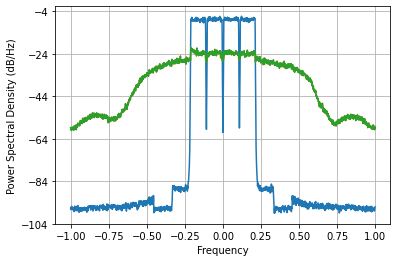

Loss =  0.0013056173736270046 Accuracy =  -13.887241061576336 dbs


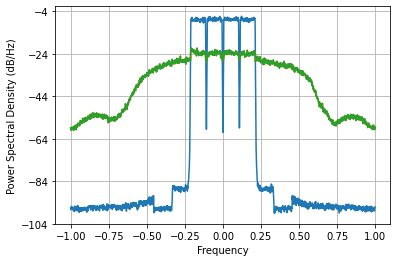

Loss =  0.001305016259479575 Accuracy =  -13.889241040114314 dbs


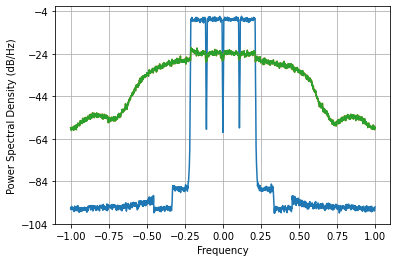

Loss =  0.0013048085237251845 Accuracy =  -13.889932415969096 dbs


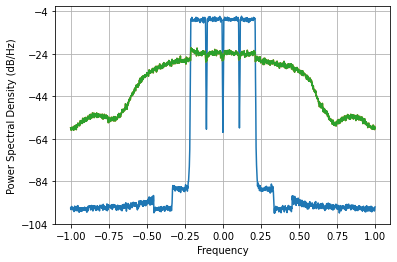

Loss =  0.001304726717997543 Accuracy =  -13.890204707950799 dbs


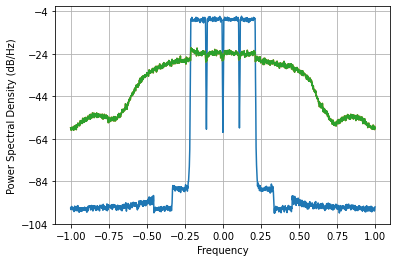

Loss =  0.001304670998196788 Accuracy =  -13.890390182183832 dbs

defaultdict(<class 'list'>, {'iter': [0, 1, 2, 3, 4], 'time': [2.6381290819999776, 5.178807846000041, 7.73980834300005, 10.374143437000043, 12.927135322000026], 'train_loss': [0.0013056173736270046, 0.001305016259479575, 0.0013048085237251845, 0.001304726717997543, 0.001304670998196788], 'train_loss_db': [-13.887241061576336, -13.889241040114314, -13.889932415969096, -13.890204707950799, -13.890390182183832]})


In [ ]:
net = new_Cell(D1=5,D2=-1)
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.999)
hist = train(train_queue, valid_queue, net, loss_fn, optimizer,5,scheduler,save_flag=False)
print(hist)

In [25]:
def Comparison_best_res(hist):

    fig, ax = plt.subplots()
    ax.plot(hist['iter'], hist['train_loss_db'], label='Olga')
    ax.set_xlabel('iter')
    ax.set_ylabel('accuracy, dbs')
    plt.title('Big model last iter')
    ax.legend()
    plt.show()
 
    fig, ax = plt.subplots()
    ax.plot(hist['time'], hist['train_loss_db'], label='Olga')
    ax.set_xlabel('time')
    ax.set_ylabel('accuracy, dbs')
    plt.title('Big model last time')
    ax.legend()
    plt.show()

defaultdict(<class 'list'>, {'iter': [0, 1, 2, 3, 4], 'time': [2.2883804910002254, 4.686953070000072, 7.095851953999954, 9.49599452099983, 11.89806173299985], 'train_loss': [0.001305814135239875, 0.0013050364742258514, 0.0013048301518369272, 0.0013047524596000904, 0.001304703365251969], 'train_loss_db': [-13.886586612224773, -13.889173768272268, -13.889860429224939, -13.890119024677002, -13.890282441158561]})
[0, 1, 2, 3, 4]


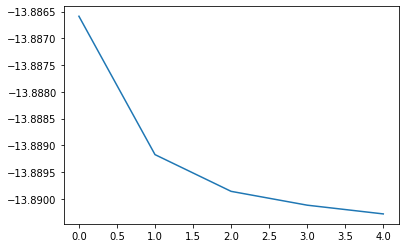

In [ ]:
print(hist)
print(hist['iter'])
plt.plot(hist['iter'], hist['train_loss_db'])
plt.show()

In [ ]:
class Olga_Cell(nn.Module):
    def __init__(self,M=15,D=2,Poly_order=2,Passthrough=True):
        super(Olga_Cell,self).__init__()
        self.f1=AFIR(M,0)
        self.f2=AFIR(M,3)
        self.f3=AFIR(M,4)
        self.delay=Delay(D)
        self.pol_smal=Polynomial(2,Passthrough)
        self.pol_big=Polynomial(10,Passthrough)
        self.prod=Prod_cmp()
        
    def forward(self,x):
        source = x.clone()
        x=self.delay(x)
        up=self.f1(x) 

        mid = self.pol_smal(source)
        mid = self.prod(x,mid)
        mid = self.f2(mid)

        low = self.pol_big(source)
        low = self.prod(low, source)
        low = self.f3(low)
        return up+mid+low

In [ ]:
net = Olga_Cell()
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist = train(train_queue, valid_queue, net, loss_fn, optimizer,100,scheduler,save_flag=False)

Output hidden; open in https://colab.research.google.com to view.

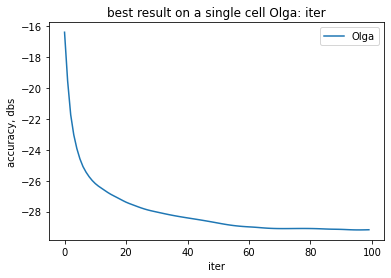

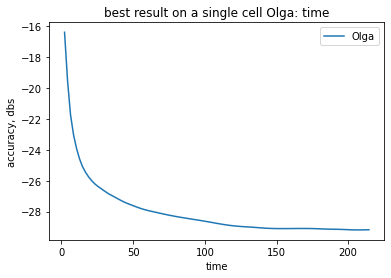

In [ ]:
Comparison_best_res(hist)

In [ ]:
class Olga_Cell(nn.Module):
    def __init__(self,M=15,D=2,Poly_order=2,Passthrough=True):
        super(Olga_Cell,self).__init__()
        self.f1=AFIR(M,0)
        self.f3=AFIR(M,4)
        self.delay=Delay(D)
        self.pol_big=Polynomial(10,Passthrough)
        self.prod=Prod_cmp()
 
    def forward(self,x):
        #source = x.clone()
        up=self.delay(x)
        up=self.f1(up)  
        low = self.pol_big(x)
        low = self.prod(low, x)
        low = self.f3(low)
        return up+low

In [ ]:
class Cell(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell,self).__init__()
        self.f1=AFIR(M,0)
        self.f2=AFIR(M,0)
        self.delay=Delay(D)
        self.pol=Polynomial(Poly_order,True) # было Passthrough
        self.prod=Prod_cmp()
    def forward(self,x):
        x=self.delay(x)
        up=self.f1(x) 
        return self.prod(up,self.f2(self.pol(x)))

In [ ]:
net = Olga_Cell()
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist = train(train_queue, valid_queue, net, loss_fn, optimizer,100,scheduler,save_flag=False)

Output hidden; open in https://colab.research.google.com to view.

In [21]:
class Cell(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell,self).__init__()
        self.f1=AFIR(M,0)
        self.f2=AFIR(M,0)
        self.delay=Delay(D)
        self.pol=Polynomial(Poly_order,Passthrough)
        self.prod=Prod_cmp()
    def forward(self,x):
        x=self.delay(x)
        up=self.f1(x) 
        return self.prod(up,self.f2(self.pol(x)))

In [22]:
class layer(nn.Module):
    def __init__(self, delay, width):
        super(layer, self).__init__()
        self.Cells = nn.ModuleList()
        for i in range(width):
#             print(i)
            self.Cells.append(Cell(D=delay[i]))

    def forward(self, x):
        out = torch.zeros_like(x)
        for i in range(len(self.Cells)):
            out += self.Cells[i](x)
        return out

In [23]:
class Model(nn.Module):
    def __init__(self, layers, width, delay):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(layers):
            self.layers.append(layer(delay[i], width))
    def forward(self, x):
        out = x.clone()
        for i in range(len(self.layers)):
            out = self.layers[i](out) + x
        return out

In [24]:
net = Model(4,7,[[1,0,0,3,0,2,0],[0,1,0,1,0,1,4],[0,0,1,0,1,0,2],[1,2,3,-2,-1,0,4]])
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist=defaultdict(list)
my_train(train_queue, valid_queue, net, loss_fn, optimizer,102,X,D,hist,scheduler,save_flag=True)

Output hidden; open in https://colab.research.google.com to view.

In [28]:
print(hist)

defaultdict(<class 'list'>, {'iter': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75], 'time': [30.277957606, 60.349915287000016, 90.66425875600001, 121.160296219, 151.649466933, 182.628108609, 213.105710581, 243.38788344500003, 273.816260724, 304.30561279000005, 334.60492041300006, 364.88120404000006, 395.0748494830001, 425.381825596, 455.72345679600005, 486.1437

In [ ]:
global hist
hist

defaultdict(list,
            {'iter': [0],
             'time': [21.199687885000458],
             'train_loss': [4.804782307752214e-06],
             'train_loss_db': [-38.22866310996611]})

In [ ]:
#net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.97)
hist = my_train(train_queue, valid_queue, net, loss_fn, optimizer,102,X,D,scheduler,save_flag=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/huawei/new_folder/hist.pkl', 'rb') as f:
    hist_new = pickle.load(f)

In [ ]:
hist_new

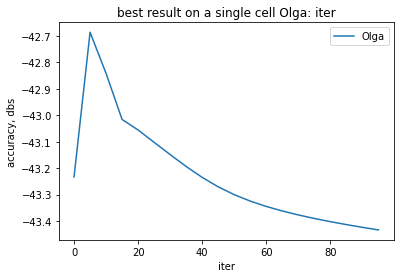

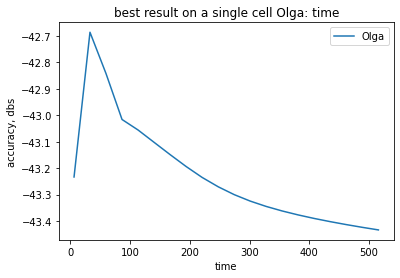

In [ ]:
Comparison_best_res(hist_new)

In [29]:
model = Model(4,7,[[1,0,0,3,0,2,0],[0,1,0,1,0,1,4],[0,0,1,0,1,0,2],[1,2,3,-2,-1,0,4]])
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/huawei/new_folder/best_new_model.pth'))
model.eval()

Model(
  (layers): ModuleList(
    (0): layer(
      (Cells): ModuleList(
        (0): Cell(
          (f1): AFIR(
            (real): Conv1d(1, 1, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
            (imag): Conv1d(1, 1, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
          )
          (f2): AFIR(
            (real): Conv1d(1, 1, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
            (imag): Conv1d(1, 1, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
          )
          (delay): Delay(
            (op): Sequential(
              (0): ConstantPad1d(padding=(1, 1), value=0)
            )
          )
          (pol): Polynomial(
            (Abs): ABS()
          )
          (prod): Prod_cmp()
        )
        (1): Cell(
          (f1): AFIR(
            (real): Conv1d(1, 1, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
            (imag): Conv1d(1, 1, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
       

In [30]:
def train_of_epoch(train_queue, model, criterion, optimizer, mode = None):
    for step, (train) in enumerate(train_queue):
 
        input_batch = Variable(train[:,:,:1],requires_grad=False).permute(2,1,0).cuda()
        desired = Variable(train[:,:,1:],requires_grad=False).permute(2,1,0).cuda()
        if mode == 'nts':
            optimizer.set_x(input_batch, desired)
            optimizer.zero_grad()
            optimizer.step()
        elif mode == 'bdgm':
            def closure():
                optimizer.zero_grad()
                out = model.forward(input_batch)
                loss = criterion(out, desired)
                loss.backward()
                return loss
            optimizer.step(closure)
            
        else:
            optimizer.zero_grad()
            out = model.forward(input_batch)
            loss = criterion(out, desired)
            loss.backward()
            optimizer.step()
 
def train(train_queue, valid_queue, model, criterion, optimizer,n_epoch,
          scheduler = False,log_every=1,save_flag=True,path_to_experiment='', mode =None):
    min_loss=0
    hist=defaultdict(list)
    t0=timer()
    for it in tqdm_notebook(range(n_epoch)):
        model.train(True)
        train_of_epoch(train_queue, model, criterion, optimizer, mode)
        if scheduler:
          scheduler.step()
        if it%log_every==0:
            loss_v,accuracy_v=eval_model(valid_queue,net, loss_fn)
            update_history(hist,it, accuracy_v, loss_v, timer() - t0,)
            print('Loss = ',loss_v.cpu().detach().numpy(), 'Accuracy = ', accuracy_v.cpu().detach().numpy(), 'dbs')
            
            if save_flag:
                with open(path_to_experiment + '/hist.pkl', 'wb') as output:
                    pickle.dump(hist, output)
 
                    torch.save(model.state_dict(), path_to_experiment + '/model.pt')
                if hist['train_loss_db'][-1] < min_loss:
                            min_loss = hist['train_loss_db'][-1]
                            torch.save(model.state_dict(), path_to_experiment + '/best_model.pth')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


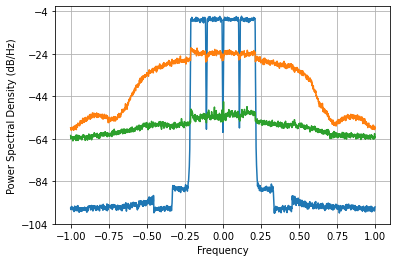

Loss =  2.029279190743488e-06 Accuracy =  -41.971982247717044 dbs


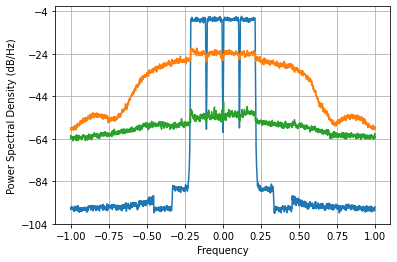

Loss =  2.028835090070928e-06 Accuracy =  -41.972932790057286 dbs


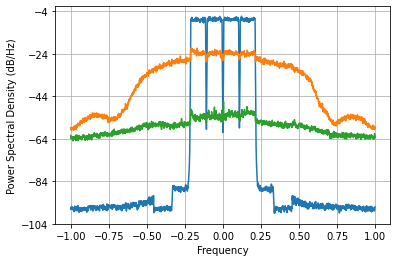

Loss =  2.0283948979430797e-06 Accuracy =  -41.9738751719948 dbs


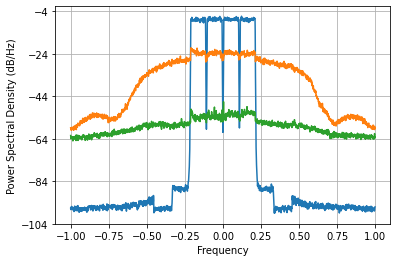

Loss =  2.027958568687796e-06 Accuracy =  -41.974809485979776 dbs


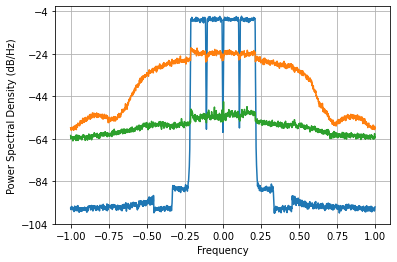

Loss =  2.0275260571791573e-06 Accuracy =  -41.97573582341957 dbs


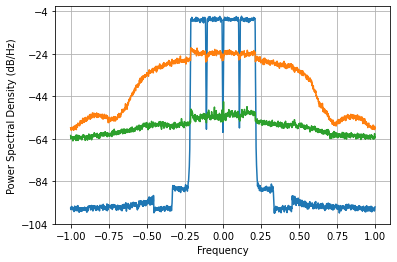

Loss =  2.027126595340623e-06 Accuracy =  -41.97659155182659 dbs


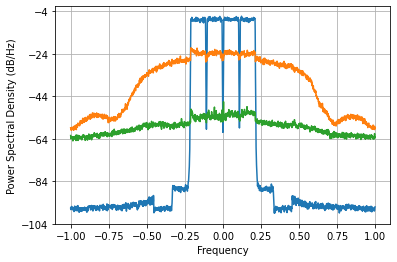

Loss =  2.0267303894075614e-06 Accuracy =  -41.9774404720111 dbs


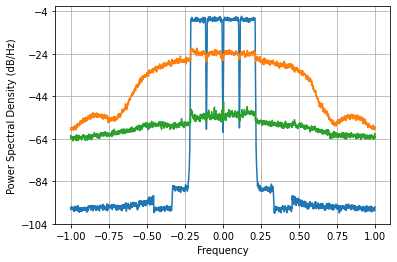

Loss =  2.0263374038973817e-06 Accuracy =  -41.97828265599507 dbs


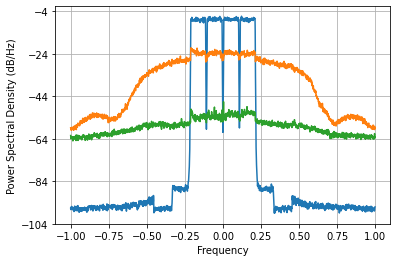

Loss =  2.0259476037232543e-06 Accuracy =  -41.97911817504111 dbs


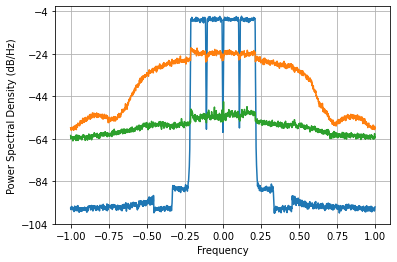

Loss =  2.025560954189239e-06 Accuracy =  -41.979947099660976 dbs


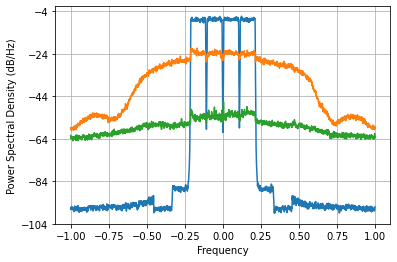

Loss =  2.0252029055379006e-06 Accuracy =  -41.98071484895132 dbs


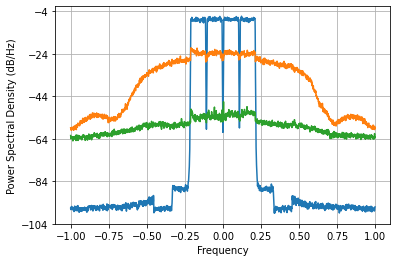

Loss =  2.0248475191365355e-06 Accuracy =  -41.98147702392333 dbs


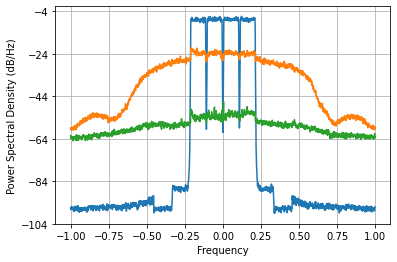

Loss =  2.024494768072402e-06 Accuracy =  -41.982233679351104 dbs


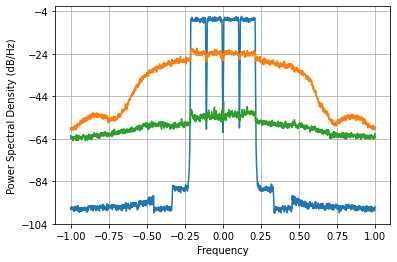

Loss =  2.0241446257122004e-06 Accuracy =  -41.98298486946959 dbs


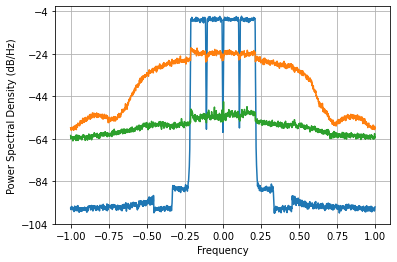

Loss =  2.023816837875421e-06 Accuracy =  -41.98368821830499 dbs


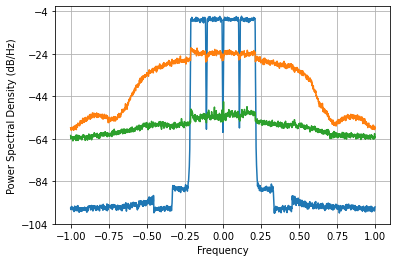

Loss =  2.0235075320098967e-06 Accuracy =  -41.984352014030776 dbs


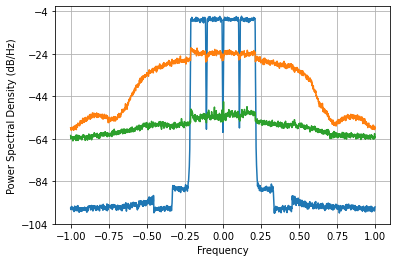

Loss =  2.0232002491181496e-06 Accuracy =  -41.98501156876881 dbs


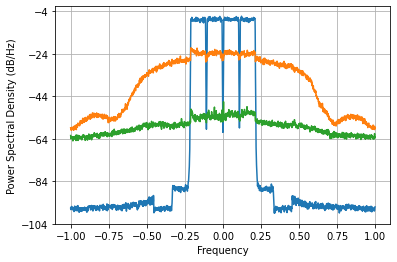

Loss =  2.022894971052848e-06 Accuracy =  -41.98566691953168 dbs


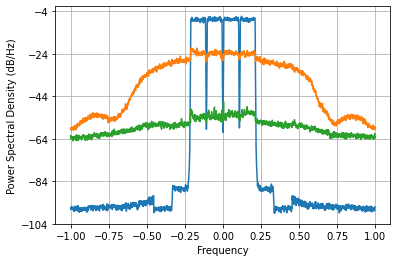

Loss =  2.0225985367485223e-06 Accuracy =  -41.986303379743994 dbs


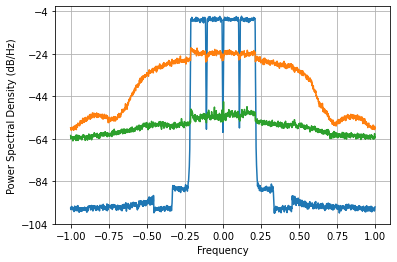

Loss =  2.0223039945589253e-06 Accuracy =  -41.98693586988122 dbs



In [31]:
net = model
net=net.to("cuda:0")
optimizer = torch.optim.LBFGS(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False, mode ='bdgm')

In [34]:
!pip3 install torch_optimizer

     |████████████████████████████████| 51kB 6.5MB/s 


In [35]:
import torch_optimizer as optim

In [37]:
optimizer = optim.DiffGrad(net.parameters(), lr= 1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.97)
train(train_queue, valid_queue, net, loss_fn, optimizer,100,scheduler,save_flag=False)#, mode ='bdgm')

Output hidden; open in https://colab.research.google.com to view.

In [63]:
cd /content/drive/My Drive/Colab Notebooks/huawei/

/content/drive/My Drive/Colab Notebooks/huawei


In [68]:
import OPTAMI as opt

ModuleNotFoundError: ignored

In [61]:
cd /content/drive/My Drive/Colab Notebooks/huawei/OPTAMI/

/content/drive/My Drive/Colab Notebooks/huawei/OPTAMI


In [56]:
from NTS import NTS
from a2grad import A2Grad
from bdgm import BDGM
from hyperfast import Hyperfast

ModuleNotFoundError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


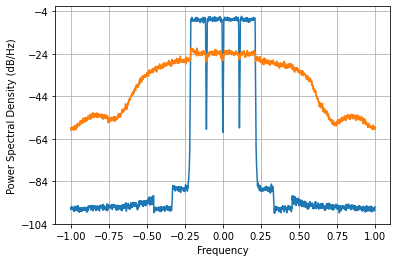

Loss =  nan Accuracy =  nan dbs
cur_batch =  10000


KeyboardInterrupt: ignored

In [74]:
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.97)
hist=defaultdict(list)
my_train(train_queue, valid_queue, net, loss_fn, optimizer,302,X,D,hist,scheduler,save_flag=False)